# Preprocessing Template

Copy this notebook and set the paths to start preprocessing your data.

Note: If you are going to update this notebooks, clear the outputs before committing.

## Loading the Data

The code below loads data and labels from GCS.

You should update the paths to save the data to the right place on
your local disk.

### Arrays

In [ ]:
# Keeps the data in the local filesystem in-sync with GCS
!gsutil rsync -d -r gs://elvos/numpy /home/lzhu7/elvo-analysis/data/numpy/

In [1]:
import os
import pathlib
import typing

import numpy as np

In [2]:
def load_data(data_dir: str) -> typing.Dict[str, np.ndarray]:
    """Returns a dictionary which maps patient ids
    to patient pixel data."""
    data_dict = {}
    for filename in os.listdir(data_dir):
        patient_id = filename[:-4] # remove .npy extension
        data_dict[patient_id] = np.load(pathlib.Path(data_dir) / filename)
    return data_dict

In [3]:
data_dict = load_data('/home/lzhu7/elvo-analysis/data/numpy/')

### Labels

In [ ]:
!gsutil cp gs://elvos/labels.csv /home/lzhu7/elvo-analysis/data/labels.csv

In [4]:
import pandas as pd

In [5]:
labels_df = pd.read_csv('/home/lzhu7/elvo-analysis/data/labels.csv',
                        index_col='patient_id')

## Preprocessing: Part I

If we use gs://elvos/numpy or gs://elvos/labels.csv, we'll have to do some minor
preprocessing first (removing bad data and duplicate labels).

In [6]:
def process_images(data: typing.Dict[str, np.ndarray]):
    return {id_: arr for id_, arr in data.items() if len(arr) != 1} # Remove the bad image

In [7]:
data_dict = process_images(data_dict)

In [8]:
def process_labels(labels: pd.DataFrame, data: typing.Dict[str, np.ndarray]):
    # TODO: Remove duplicate HLXOSVDF27JWNCMJ, IYDXJTFVWJEX36DO from ELVO_key
    labels = labels.loc[~labels.index.duplicated()] # Remove duplicate ids
    labels = labels.loc[list(data.keys())]
    assert len(labels) == len(data)
    return labels

In [9]:
labels_df = process_labels(labels_df, data_dict)

## Data Exploration

Simple plotting of the (mostly) unprocessed data.

For the data in `numpy/`:
- The 6 smallest image heights are: 1, 160, 160, 162, 164, 181.
- The 5 smallest image lengths/widths are: 180, 191, 193, 195, 197.

In [10]:
%matplotlib inline

In [11]:
from matplotlib import pyplot as plt

In [12]:
def plot_images(data: typing.Dict[str, np.ndarray],
                labels: pd.DataFrame,
                num_cols: int,
                limit=20,
                offset=0):
    # Ceiling function of len(data) / num_cols
    num_rows = (min(len(data), limit) + num_cols - 1) // num_cols 
    fig = plt.figure(figsize=(10, 10))
    for i, patient_id in enumerate(data):
        if i < offset:
            continue
        if i >= offset + limit:
            break
        plot_num = i - offset + 1
        ax = fig.add_subplot(num_rows, num_cols, plot_num)
        ax.set_title(f'patient: {patient_id[:4]}...')
        label = 'positive' if labels.loc[patient_id]["label"] else 'negative'
        ax.set_xlabel(f'label: {label}')
        plt.imshow(data[patient_id])
    fig.tight_layout()
    plt.plot()

In [13]:
# Change the input to .transpose to see different views of the data
mipped_all = {k:data_dict[k].transpose(2, 1, 0).max(axis=2) for i, k in enumerate(data_dict)}

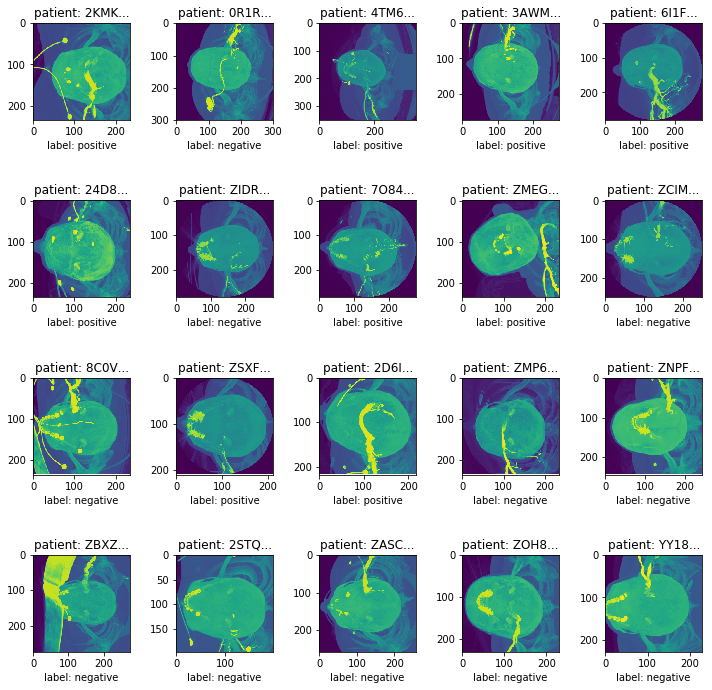

In [14]:
plot_images({k: arr for k, arr in mipped_all.items()}, labels_df, 5, offset=20)

## Preprocessing: Part II

Cropping the image, applying mip, etc.

You should

In [15]:
import scipy.ndimage

In [16]:
def crop(image3d: np.ndarray,
         output_shape) -> np.ndarray:
    """Crops a 3d image in ijk form (height as axis 0).
    """
    assert image3d.shape[1] == image3d.shape[2]
    assert output_shape[1] == output_shape[2] # For now
    assert output_shape[1] <= image3d.shape[1]
    
    lw_center = image3d.shape[1] // 2
    lw_min = lw_center - output_shape[1] // 2
    lw_max = lw_center + output_shape[1] // 2
    for i in range(len(image3d) - 1, 0, -1):
        if image3d[i, lw_center, lw_center] >= 0:
            height_max = i - 30
            break
    height_min = height_max - output_shape[0]
    
    cropped = image3d[height_min:height_max, lw_min:lw_max, lw_min:lw_max]
    assert cropped.shape == output_shape
    return cropped


def transpose(image3d: np.ndarray) -> np.ndarray:
    """Move height from the first axis to the last.
    """
    return image3d.transpose(1, 2, 0)


def bound_pixels(image3d: np.ndarray,
                 min_bound: float,
                 max_bound: float) -> np.ndarray:
    image3d[image3d < min_bound] = min_bound
    image3d[image3d > max_bound] = max_bound
    return image3d


def mip(image3d: np.ndarray) -> np.ndarray:
    """Make sure that the array has been transposed first!
    """
    assert image3d.shape[0] == image3d.shape[1]
    return image3d.max(axis=2)


def downsample(image3d: np.ndarray, factor) -> np.ndarray:
    return scipy.ndimage.zoom(image3d, factor)
    

def to_grayscale(image2d: np.ndarray):
    return np.stack([image2d, image2d, image2d], axis=2)


def process_data(data: typing.Dict[str, np.ndarray]) -> typing.Dict[str, np.ndarray]:
    processed = {}
    for id_, arr in data.items():
        try:
            arr = crop(arr, (50, 196, 196))
            arr = transpose(arr)
            arr = bound_pixels(arr, -200, 400)
            arr = mip(arr)
            processed[id_] = arr
        except AssertionError:
            print(f'image for patient {id_} too small')
    return processed

In [17]:
processed_dict = process_data(data_dict)

## Data Validation

Check to see that the data looks right.

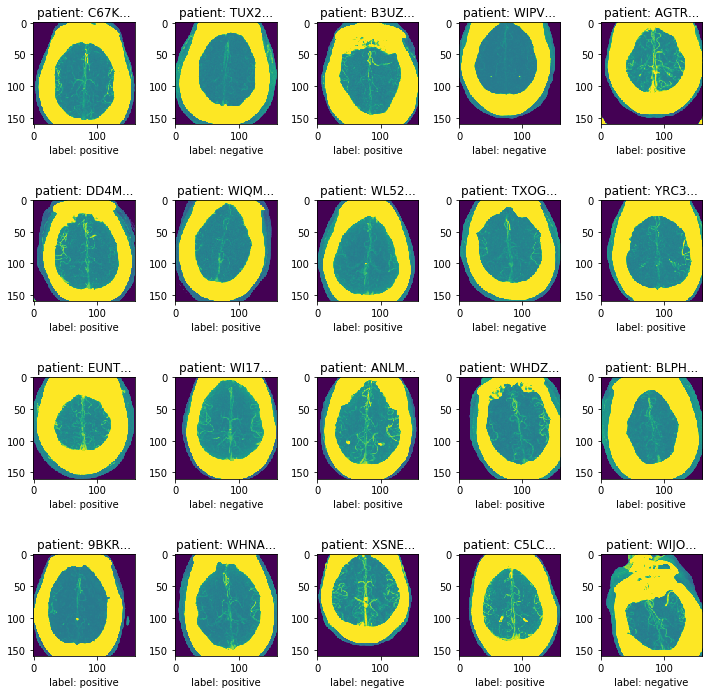

In [18]:
plot_images({k: arr for k, arr in processed_dict.items()}, labels_df, 5, offset=140)

In [ ]:
os.mkdir('mip')
for i in range(38):
    plot_images(processed_dict, labels_df, 5, offset=20 * i)
    plt.savefig(f'mip/{20 * i}-{20 * (i + 1) - 1}.png')

/gpfs/main/home/lzhu7/elvo-analysis/venv/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [19]:
filtered_df = labels_df.loc[processed_dict.keys()]

## Saving the Data

Once you've preprocessed data to your liking, you should save the data to 
disk. Load the data from disk in your model building notebook.

In [ ]:
# Changed the preprocessed path
processed_dirpath = '/home/lzhu7/elvo-analysis/data/luke5/'
os.mkdir(processed_dirpath)
arr: np.ndarray
for id_, arr in processed_dict.items():
    np.save(pathlib.Path(processed_dirpath) / f'{id_}.npy', arr)

In [ ]:
filtered_df.to_csv('/home/lzhu7/elvo-analysis/data/labels5.csv')

## Sharing the Data
If the data works well in models, you should share it with others.
Make sure to update the [Code and Data Doc](https://docs.google.com/document/d/1_vaNcfZ_E5KsOZH_rNf4w_wTIr7EvI8GqpZ5o3dAUV4/edit)
if you do upload to GCS.

In [ ]:
!gsutil rsync -d -r PATH/TO/PROCESSED/DATA gs://PATH/TO/SAVE/TO

In [ ]:
!gsutil rsync -d PATH/TO/PROCESSED/LABELS gs://PATH/TO/SAVE/TO